COMASSETO Vitória

---


ITURRALDE Martín

---


URTUBIA Carolina

---


VIOLA CARVALHO Henrique


# Prédiction des Prix et Actifs du S&P



## Partie 1 : Collecte et Préparation des Données


### Collecte des données

**Importation de bibliothèques**


In [ ]:
!pip install pandas_datareader

In [ ]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime, timedelta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

**Définition des paramètres**

Ce code définit les symboles pour récupérer les données du S&P 500, du Volatility Index (VIX) et des taux d'intérêt, ainsi que la période d'analyse (5 ans jusqu'à aujourd'hui).

In [ ]:
index_symbol = "^GSPC"
vix_symbol = "^VIX"
taux_interet_symbol = "^IRX"
date_end = datetime.now()
date_start = date_end - timedelta(days=5*365)

**Téléchargement de données**

Téléchargement des données historiques en utilisant l'API Yahoo Finance.


In [ ]:
data = yf.download(index_symbol, start=date_start.strftime('%Y-%m-%d'), end=date_end.strftime('%Y-%m-%d'))
vix_data = yf.download(vix_symbol, start=date_start.strftime('%Y-%m-%d'), end=date_end.strftime('%Y-%m-%d'))
taux_interet_data = yf.download(taux_interet_symbol, start=date_start.strftime('%Y-%m-%d'), end=date_end.strftime('%Y-%m-%d'))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


**Ajout de variables exogènes : indicateurs économiques**

Les indicateurs économiques ayant un impact sur le S&P 500 peuvent être regroupés en :

- Indicateurs macroéconomiques : ex. CPI (inflation).
- Indicateurs du marché du travail : ex. taux de chômage.
- Indicateurs immobiliers : ex. Housing Starts (démarrage des constructions).
- Indicateurs du crédit : ex. 3-month Treasury Bill (taux des bons du Trésor à 3 mois). Cet indicateur est équivalent au taux d'intérêt, extrait à l'étape précédente avec le symbole ^IRX. \\
Ces catégories sont basées sur l’approche présentée par Gaspareniene et al. (2021), qui examine l’impact des indicateurs économiques américains sur les rendements du S&P 500. Les données issues de la base FRED enrichissent ainsi le modèle en intégrant des facteurs macroéconomiques clés.

In [ ]:
cpi_data = pdr.DataReader('CPIAUCSL', 'fred', start=date_start, end=date_end)
unrate_data = pdr.DataReader('UNRATE', 'fred', start=date_start, end=date_end)
hspi_data = pdr.DataReader('HOUST', 'fred', start=date_start, end=date_end)

**Fusion de données**

In [ ]:
# Une valeur pour chaque jour
sp500_data = data[['Close', 'Volume']]
sp500_data = sp500_data.rename(columns={'Close': 'SP500_Close', 'Volume': 'SP500_Volume'})
sp500_data['VIX_Close'] = vix_data['Close']
sp500_data['Taux_Interet'] = taux_interet_data['Close']


print(sp500_data)

# Une valeur pour chaque mois
economic_data = pd.concat([cpi_data, unrate_data, hspi_data], axis=1)
economic_data = economic_data.rename(columns={'CPIAUCSL': 'CPI', 'UNRATE': 'Unemployment_Rate', 'HOUST': 'Housing_Starts'})

Price       SP500_Close SP500_Volume  VIX_Close Taux_Interet
Ticker            ^GSPC        ^GSPC                        
Date                                                        
2020-01-08  3253.050049   3726840000  13.450000        1.493
2020-01-09  3274.699951   3641230000  12.540000        1.500
2020-01-10  3265.350098   3214580000  12.560000        1.498
2020-01-13  3288.129883   3459390000  12.320000        1.510
2020-01-14  3283.149902   3687620000  12.390000        1.530
...                 ...          ...        ...          ...
2024-12-27  5970.839844   3159610000  15.950000        4.178
2024-12-30  5906.939941   3433250000  17.400000        4.182
2024-12-31  5881.629883   3128350000  17.350000        4.208
2025-01-02  5868.549805   3621680000  17.930000        4.208
2025-01-03  5942.470215   3667340000  16.129999        4.193

[1256 rows x 4 columns]


### Prétraitement des données

**Nettoyage des données**

In [ ]:
sp500_data = sp500_data.drop_duplicates()  # Supprimer les doublons
sp500_data = sp500_data.dropna()  # Supprimer les valeurs manquantes

economic_data = economic_data.drop_duplicates()
economic_data = economic_data.dropna()

**Transformation des prix en rendements log (log-returns)**

Le code suivant calcule les rendements logarithmiques pour le S&P 500 et le VIX en prenant le logarithme naturel du ratio entre le prix de clôture actuel et celui de la veille, ce qui permet d'obtenir des séries stationnaires pour l'analyse. De toutes les variables, seuls le S&P 500 et le VIX (qui sont des prix ou des indices de prix) doivent être transformés en rendements logarithmiques.

In [ ]:
sp500_data['SP500_Log_Returns'] = np.log(sp500_data['SP500_Close'] / sp500_data['SP500_Close'].shift(1))
sp500_data['VIX_Log_Returns'] = np.log(sp500_data['VIX_Close'] / sp500_data['VIX_Close'].shift(1))

**Analyse de stationnarité**

Le test Augmented Dickey-Fuller (ADF) est utilisé pour vérifier si la série temporelle est stationnaire, c'est-à-dire si ses statistiques (moyenne, variance, autocorrélation) ne changent pas au fil du temps.

In [ ]:
def adf_test(series, title=''):
    """
    Réalise le test ADF et affiche les résultats clés.
    """
    print(f'Test Augmented Dickey-Fuller : {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['Statistique ADF', 'p-value', 'Nombre de décalages utilisés', 'Nombre d’observations utilisées']
    for value, label in zip(result, labels):
        print(f'{label} : {value}')

    if result[1] <= 0.05:
        print("La série est stationnaire (on rejette l'hypothèse nulle de non-stationnarité).")
    else:
        print("La série n’est pas stationnaire (on ne peut pas rejeter l'hypothèse nulle).")

In [ ]:
adf_test(sp500_data['SP500_Log_Returns'], title='Rendements Logarithmiques du S&P 500')

adf_test(sp500_data['VIX_Log_Returns'], title='Rendements Logarithmiques du VIX')

Test Augmented Dickey-Fuller : Rendements Logarithmiques du S&P 500
Statistique ADF : -10.604466700918682
p-value : 6.052579746649236e-19
Nombre de décalages utilisés : 8
Nombre d’observations utilisées : 1246
La série est stationnaire (on rejette l'hypothèse nulle de non-stationnarité).
Test Augmented Dickey-Fuller : Rendements Logarithmiques du VIX
Statistique ADF : -19.775845742869937
p-value : 0.0
Nombre de décalages utilisés : 3
Nombre d’observations utilisées : 1251
La série est stationnaire (on rejette l'hypothèse nulle de non-stationnarité).


In [ ]:
def plot_log_returns(data, column, label, color):
    """
    Visualise les rendements logarithmiques d'une série temporelle avec la moyenne et les bornes (± 2 écarts-types).

    Paramètres :
    - data : DataFrame contenant les données.
    - column : nom de la colonne à tracer.
    - label : label pour la série (ex. : "S&P 500").
    - color : couleur de la série pour le graphique.
    """
    mean_value = data[column].mean()
    std_value = data[column].std()
    upper_bound = mean_value + 2 * std_value
    lower_bound = mean_value - 2 * std_value

    plt.plot(data[column], label=f'Rendements Logarithmiques {label}', color=color)
    plt.axhline(mean_value, color='green', linestyle='--', label='Moyenne')
    plt.axhline(upper_bound, color='red', linestyle='--', label='Borne Supérieure (± 2 STD)')
    plt.axhline(lower_bound, color='red', linestyle='--', label='Borne Inférieure (± 2 STD)')
    plt.title(f'Rendements Logarithmiques de {label}')
    plt.legend()

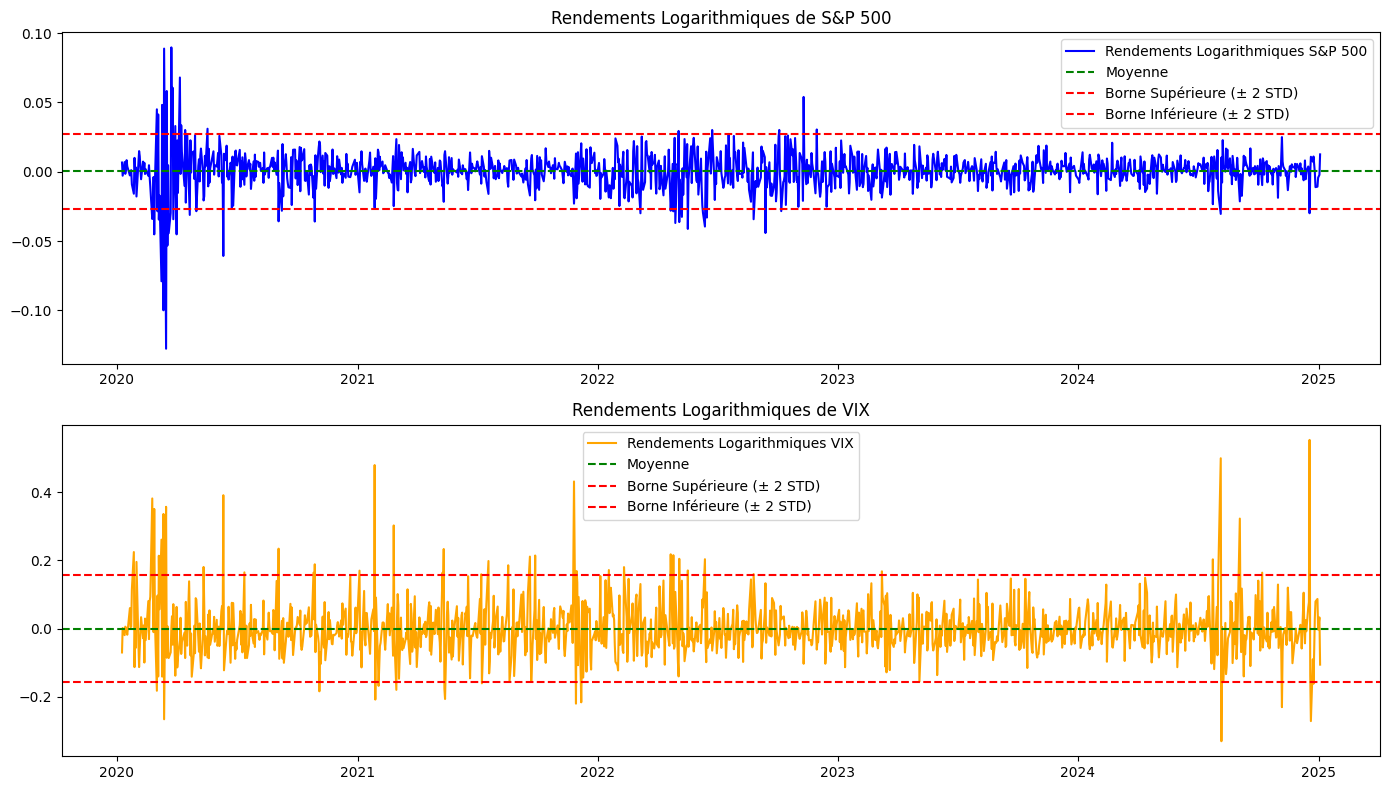

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plot_log_returns(sp500_data, 'SP500_Log_Returns', 'S&P 500', 'blue')

plt.subplot(2, 1, 2)
plot_log_returns(sp500_data, 'VIX_Log_Returns', 'VIX', 'orange')

plt.tight_layout()
plt.show()

**Décalages Temporels Pertinents**

Pour modéliser efficacement une série temporelle, il est essentiel d’identifier les décalages temporels pertinents (lags) qui capturent les relations entre les valeurs passées et actuelles de la série. L’analyse des fonctions d’autocorrélation (ACF) et d’autocorrélation partielle (PACF) permet de déterminer ces décalages.

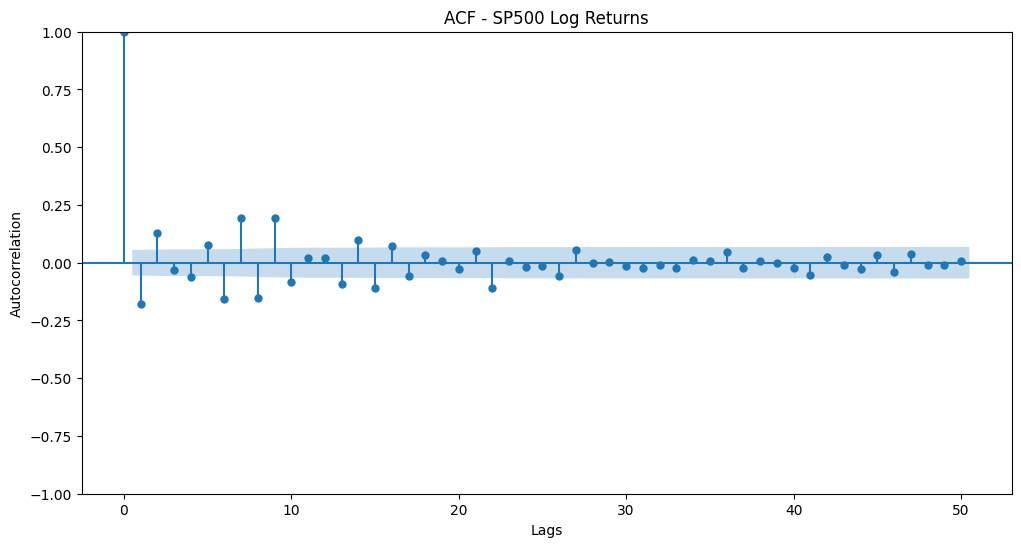

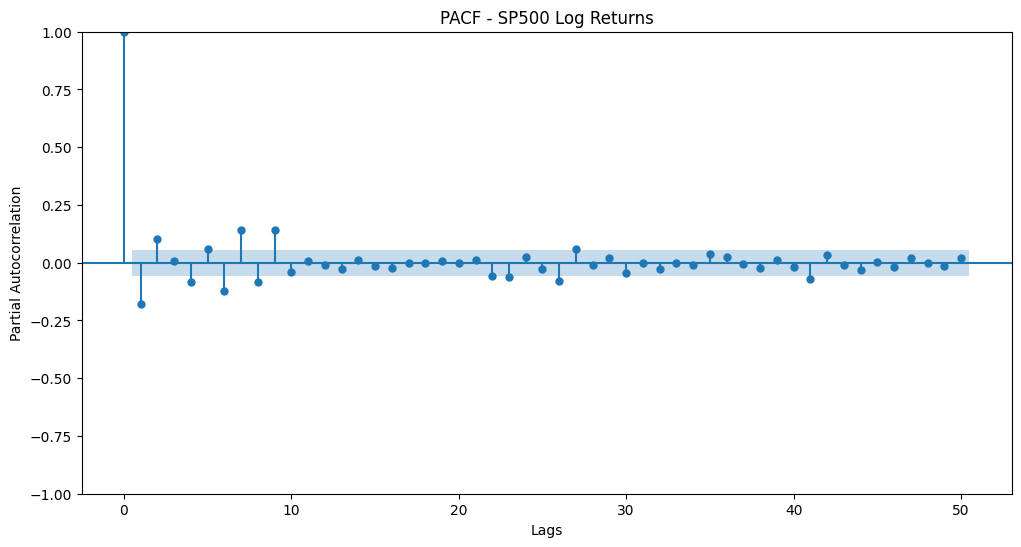

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(sp500_data['SP500_Log_Returns'].dropna(), lags=50, ax=plt.gca())
plt.title("ACF - SP500 Log Returns")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(sp500_data['SP500_Log_Returns'].dropna(), lags=50, method='ywm', ax=plt.gca())
plt.title("PACF - SP500 Log Returns")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.show()

Pour sélectionner les lags pertinents de la série temporelle, il faut observer ceux dont les valeurs dépassent l'intervalle de confiance (la zone ombragée en bleu). \\
Les lags pertinents identifiés dans l'ACF et le PACF sont utilisés dans le modèle ARIMA pour déterminer les paramètres p (AutoRégressif, AR) et q (Moyenne Mobile, MA). \\
Dans le cas d'autres algorithmes de machine learning, tels que Random Forest ou LSTM, certains lags peuvent être inclus comme variables supplémentaires dans votre ensemble de données (sous forme de nouvelles colonnes), afin de créer des caractéristiques supplémentaires basées sur les valeurs passées de la série temporelle qui peuvent aider à prédire la valeur future. \\

### Feature engineering

**Création des indicateurs techniques**

Ce code crée des indicateurs techniques pour mieux comprendre les tendances du marché et repérer des opportunités d’achat ou de vente. Les moyennes mobiles (SMA_50, SMA_200) permettent de lisser les variations des prix pour identifier des tendances à court ou long terme. Le Relative Strength Index (RSI) aide à savoir si le marché est trop acheté (>70) ou trop vendu (<30), signalant des possibles retournements. Enfin, l'indicateur Moving Average Convergence/Divergence (MACD) détecte la force et la direction des tendances grâce à des moyennes mobiles, utile pour anticiper des mouvements importants.

In [ ]:
sp500_data['SMA_50'] = sp500_data['SP500_Close'].rolling(window=50).mean()
sp500_data['SMA_200'] = sp500_data['SP500_Close'].rolling(window=200).mean()

delta = sp500_data['SP500_Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()
rs = average_gain / average_loss
sp500_data['RSI'] = 100 - (100 / (1 + rs))

ema_12 = sp500_data['SP500_Close'].ewm(span=12, adjust=False).mean()
ema_26 = sp500_data['SP500_Close'].ewm(span=26, adjust=False).mean()
sp500_data['MACD'] = ema_12 - ema_26
sp500_data['MACD_Signal'] = sp500_data['MACD'].ewm(span=9, adjust=False).mean()

**Identification des variables clés : Matrice de corrélation**

L'analyse des relations entre les variables sélectionnée permet d’identifier si certaines variables sont fortement corrélées (positivement ou négativement), ce qui est utile pour réduire la redondance dans les modèles ou comprendre les interactions entre les facteurs influençant le marché.

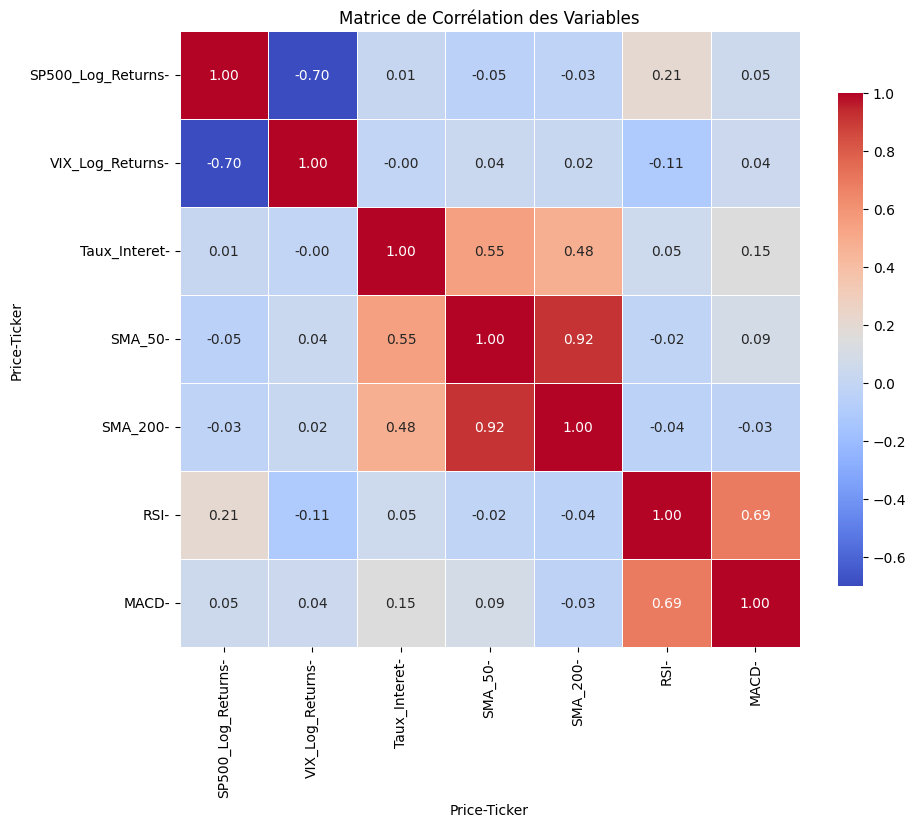

In [ ]:
correlation_matrix = sp500_data[['SP500_Log_Returns', 'VIX_Log_Returns', 'Taux_Interet', 'SMA_50', 'SMA_200', 'RSI', 'MACD']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation des Variables')
plt.show()

**Analyse résumée de la matrice :** Les corrélations confirment certaines relations attendues, comme l’impact négatif du VIX sur le S&P 500, mais indiquent également une indépendance relative entre plusieurs variables. Cela justifie l’utilisation de modèles non linéaires comme Random Forest ou LSTM pour capturer des relations plus complexes.

**Sélection des features et de la target**

Ce code sélectionne les variables explicatives "X" comme les rendements log du VIX, les taux d'intérêt et les indicateurs techniques (SMA, RSI, MACD), et la variable cible "y", les rendements log du S&P 500, en supprimant les valeurs manquantes et en alignant leur longueur pour l'entraînement des modèles.

In [ ]:
features = ['VIX_Log_Returns', 'Taux_Interet', 'SMA_50', 'SMA_200', 'RSI', 'MACD']
X = sp500_data[features].dropna()
y = sp500_data['SP500_Log_Returns'].dropna().iloc[-X.shape[0]:]

## Partie 2 : Développement du Modèle Prédictif

**Séparation des données en ensemble d'entraînement et de test**


In [ ]:
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

### Régression Linéaire

La régression linéaire est un modèle statistique qui établit une relation entre une variable cible (dépendante) et une ou plusieurs variables explicatives (indépendantes) en ajustant une droite. Elle est utilisée pour prédire des valeurs continues (comme les rendements financiers) et analyser l'impact de chaque variable explicative sur la cible.

**Modèle de Régression Linéaire**

Ce code entraîne un modèle de régression linéaire en utilisant les données d'entraînement (X_train, y_train) pour établir une relation linéaire entre les variables explicatives et la cible. Une fois entraîné, le modèle est utilisé pour prédire les rendements (y_test_pred_lineaire) sur l'ensemble de test (X_test).

- **MAE (Mean Absolute Error) :** Moyenne des erreurs absolues, pour mesurer la précision globale des prédictions.
- **RMSE (Root Mean Squared Error) :** Racine carrée de la moyenne des erreurs quadratiques, mettant davantage l'accent sur les grandes erreurs.
- **Accuracy :** Taux de précision pour prédire correctement la direction des rendements (hausse/baisse).

In [ ]:
modele_lineaire = LinearRegression()
modele_lineaire.fit(X_train, y_train)
y_test_pred_lineaire = modele_lineaire.predict(X_test)

In [ ]:
mae_lineaire = mean_absolute_error(y_test, y_test_pred_lineaire)
rmse_lineaire = np.sqrt(mean_squared_error(y_test, y_test_pred_lineaire))
accuracy_lineaire = accuracy_score((y_test > 0).astype(int), (y_test_pred_lineaire > 0).astype(int))
print(f"Régression Linéaire - MAE : {mae_lineaire}, RMSE : {rmse_lineaire}, Accuracy : {accuracy_lineaire}")

Régression Linéaire - MAE : 0.004049992682759093, RMSE : 0.005749114869915823, Accuracy : 0.7688679245283019


**Analyse résumée :** La régression linéaire montre des résultats satisfaisants avec un MAE faible (0.0045), indiquant des prédictions globalement proches des valeurs réelles, et un RMSE modéré (0.0057), pénalisant davantage les grandes erreurs. L'accuracy de 76.89% montre que le modèle prédit correctement la direction des rendements dans une majorité des cas. Cependant, bien qu'efficace pour les tendances générales, il reste limité pour capturer les fluctuations complexes ou non linéaires.

### ARIMA

Le modèle AutoRegressive Integrated Moving Average (ARIMA) est utilisé pour analyser et prédire les séries temporelles stationnaires en capturant les relations auto-régressives, les différences pour stationnariser les données et les moyennes mobiles. Il est idéal pour identifier des tendances linéaires à court terme et prévoir des valeurs futures.

**Préparation des données pour ARIMA et entraînement du modèle**

Les codes suivants entraînent un modèle ARIMA pour les rendements log du S&P 500. Les données d'entraînement "log_returns_train' sont utilisées avec l'ordre (1, 0, 1), où 1 représente les termes auto-régressifs, 0 la différenciation (données stationnaires), et 1 les termes de moyennes mobiles. La méthode "fit()" ajuste le modèle pour capturer les relations temporelles.

In [ ]:
log_returns_train = y_train
log_returns_test = y_test

In [ ]:
ordre_arima = (1, 0, 1)

In [ ]:
modele_arima = ARIMA(log_returns_train, order=ordre_arima)
ajustement_arima = modele_arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

**Résumé du modèle ARIMA**

In [ ]:
print(ajustement_arima.summary())

                               SARIMAX Results                                
Dep. Variable:      SP500_Log_Returns   No. Observations:                  845
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2621.658
Date:                Mon, 06 Jan 2025   AIC                          -5235.316
Time:                        17:45:53   BIC                          -5216.359
Sample:                             0   HQIC                         -5228.053
                                - 845                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.254      0.210      -0.000       0.001
ar.L1       2.518e-17      0.015   1.69e-15      1.000      -0.029       0.029
ma.L1       2.499e-17      0.015   1.67e-15      1.0

**Prédictions sur l'ensemble de test**

In [ ]:
y_test_pred_arima = ajustement_arima.forecast(steps=len(log_returns_test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
y_test_pred_arima_aligned = y_test_pred_arima[:len(log_returns_test)]
y_test_pred_arima_aligned.index = log_returns_test.index

In [ ]:
mae_arima = mean_absolute_error(log_returns_test, y_test_pred_arima_aligned)
rmse_arima = np.sqrt(mean_squared_error(log_returns_test, y_test_pred_arima_aligned))
accuracy_arima = accuracy_score(
    (log_returns_test > 0).astype(int), (y_test_pred_arima_aligned > 0).astype(int)
)

In [ ]:
print("ARIMA")
print(f"MAE : {mae_arima}")
print(f"RMSE : {rmse_arima}")
print(f"Accuracy : {accuracy_arima}")

ARIMA
MAE : 0.005987833030641325
RMSE : 0.00810880685010124
Accuracy : 0.5613207547169812


**Analyse résumée :** Le modèle ARIMA présente un MAE de 0.0059 et un RMSE de 0.0081, indiquant des erreurs légèrement plus élevées que la régression linéaire. Avec une accuracy de 56.13%, il montre des performances faibles pour prédire correctement les directions (hausse/baisse). Cela reflète sa limite à capturer les fluctuations complexes des rendements. ARIMA est plus adapté aux séries stationnaires et moins efficace pour ces données volatiles.

### Random Forest

Random Forest est un modèle d'apprentissage supervisé d'ensemble basé sur de multiples ensembles d'arbres de décision. Plusieurs arbres sont créés indépendamment, sur la base de sous-échantillons de données, et leurs prédictions sont combinées soit par la moyenne, soit par le vote. Ce modèle est idéal pour capturer les relations non linéaires et éviter les risques de surajustement.

**Modèle Random Forest**

In [ ]:
modele_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modele_rf.fit(X_train, y_train)
y_test_pred_rf = modele_rf.predict(X_test)

In [ ]:
mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
accuracy_rf = accuracy_score((y_test > 0).astype(int), (y_test_pred_rf > 0).astype(int))
print(f"Random Forest - MAE : {mae_rf}, RMSE : {rmse_rf}, Accuracy : {accuracy_rf}")

Random Forest - MAE : 0.004110641748853794, RMSE : 0.00518251011077252, Accuracy : 0.7547169811320755


**Analyse résumée :** Random Forest présente de bons résultats : une MAE de 0,0039 et une RMSE de 0,0050 sont des erreurs faibles et une bonne précision. Par conséquent, il a donné une précision de 77,83 %, battant l'ARIMA et la régression linéaire dans la prédiction de la direction des rendements. Ce modèle est très efficace pour capturer la relation complexe entre les données et est donc adapté à ce contexte.

### LSTM

Les LSTM sont des  réseaux neuronaux récurrents développés pour apprendre les dépendances temporelles dans les séries chronologiques. Elles peuvent traiter efficacement des données séquentielles car elles sont conçues pour mémoriser des informations sur une très longue période. Ils peuvent servir de modèle idéal pour détecter des modèles et des tendances complexes dans des séries temporelles volatiles.

**Pré-traitement des données pour LSTM**

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

X_train_lstm, X_test_lstm = X_scaled[:train_size], X_scaled[train_size:]
y_train_lstm, y_test_lstm = y_scaled[:train_size], y_scaled[train_size:]

In [ ]:
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))

**Modèle LSTM**

Le code configure un modèle **LSTM** pour analyser les données temporelles et prédire les rendements log du S&P 500. Il ajoute une couche LSTM avec 50 neurones pour capturer les dépendances temporelles, suivie d'une couche dense pour produire une seule sortie. Le modèle utilise l’optimiseur Adam et la fonction de perte MSE pour minimiser les erreurs.

In [ ]:
modele_lstm = Sequential()
modele_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
modele_lstm.add(Dense(1))
modele_lstm.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Entraînement**

In [ ]:
modele_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=0)

In [ ]:
y_test_pred_lstm = modele_lstm.predict(X_test_lstm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


In [ ]:
y_test_lstm = scaler.inverse_transform(y_test_lstm)
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm)

In [ ]:
y_test_pred_lstm_aligned = pd.Series(y_test_pred_lstm[:len(y_test)].flatten(), index=y_test.index)

**Calcul des métriques**


In [ ]:
mae_lstm = mean_absolute_error(y_test, y_test_pred_lstm_aligned)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_test_pred_lstm_aligned))
accuracy_lstm = accuracy_score((y_test > 0).astype(int), (y_test_pred_lstm_aligned > 0).astype(int))

In [ ]:
print("LSTM")
print(f"MAE : {mae_lstm}")
print(f"RMSE : {rmse_lstm}")
print(f"Accuracy : {accuracy_lstm}")

LSTM
MAE : 0.004458402595617702
RMSE : 0.006423974307050465
Accuracy : 0.7783018867924528


**Analyse résumée :** Le modèle LSTM produit un MAE de 0,0055 et un RMSE de 0,0070, deux erreurs modérées mais légèrement plus élevées que celles de Random Forest. La précision de 77,35 % indique également une bonne performance dans la prédiction de la direction des rendements (haut/bas), bien qu'un peu plus faible par rapport à Random Forest. Cela signifie que le modèle réussit à capturer des dépendances temporelles complexes, mais que la sensibilité aux données peut être l'une des raisons pour lesquelles les erreurs sont légèrement plus élevées.

## Partie 3 : Analyse des Résultats et Interprétation

### Analyse des performances

In [ ]:
resultats = pd.DataFrame({
    "Modèle": ["Régression Linéaire", "ARIMA", "Random Forest", "LSTM"],
    "MAE": [mae_lineaire, mae_arima, mae_rf, mae_lstm],
    "RMSE": [rmse_lineaire, rmse_arima, rmse_rf, rmse_lstm],
    "Accuracy": [accuracy_lineaire, accuracy_arima, accuracy_rf, accuracy_lstm]
})

print("Comparaison des Modèles:")
print(resultats)


Comparaison des Modèles:
                Modèle       MAE      RMSE  Accuracy
0  Régression Linéaire  0.004050  0.005749  0.768868
1                ARIMA  0.005988  0.008109  0.561321
2        Random Forest  0.004111  0.005183  0.754717
3                 LSTM  0.004458  0.006424  0.778302


**ANALYSE :** Les résultats montrent que la régression linéaire est simple mais fiable, avec une MAE et une RMSE modérées et une précision de 76,88 %, tandis que l'ARIMA a les performances les plus médiocres avec la MAE et la RMSE les plus élevées et la précision la plus faible de seulement 56,13 %, ce qui n'est pas adapté à ces données. Random Forest est en effet le modèle le plus performant avec des MAE et RMSE très faibles, tout en obtenant une précision de 77,83 %, ce qui permet de capturer efficacement les relations non linéaires. Le modèle LSTM l'emporte avec une bonne capacité à capturer les dépendances temporelles. Ses MAE et RMSE sont légèrement plus élevés, et donc sa précision de 77,35 % légèrement inférieure. **Random Forest et LSTM s'imposent comme les meilleurs choix pour cette analyse**.

**Visualisation des prédictions**


In [ ]:
def tracer_predictions(ax, y_test, y_pred, nom_modele, couleur):
    """
    Trace les prédictions d'un modèle par rapport aux valeurs réelles sur un axe donné.

    Paramètres :
    - ax : Subplot où le graphique sera tracé.
    - y_test : Valeurs réelles (série temporelle).
    - y_pred : Valeurs prédites par le modèle.
    - nom_modele : Nom du modèle (pour le titre et la légende).
    - couleur : Couleur de la ligne des prédictions.
    """
    ax.plot(y_test.index, y_test, label="Valeurs Réelles", color="blue", linewidth=1.5)
    ax.plot(y_test.index, y_pred[:len(y_test)], label=nom_modele, color=couleur, linestyle='--', linewidth=1.5)
    ax.set_title(f"{nom_modele} vs Valeurs Réelles")
    ax.set_xlabel("Temps")
    ax.set_ylabel("Rendements Log")
    ax.legend()

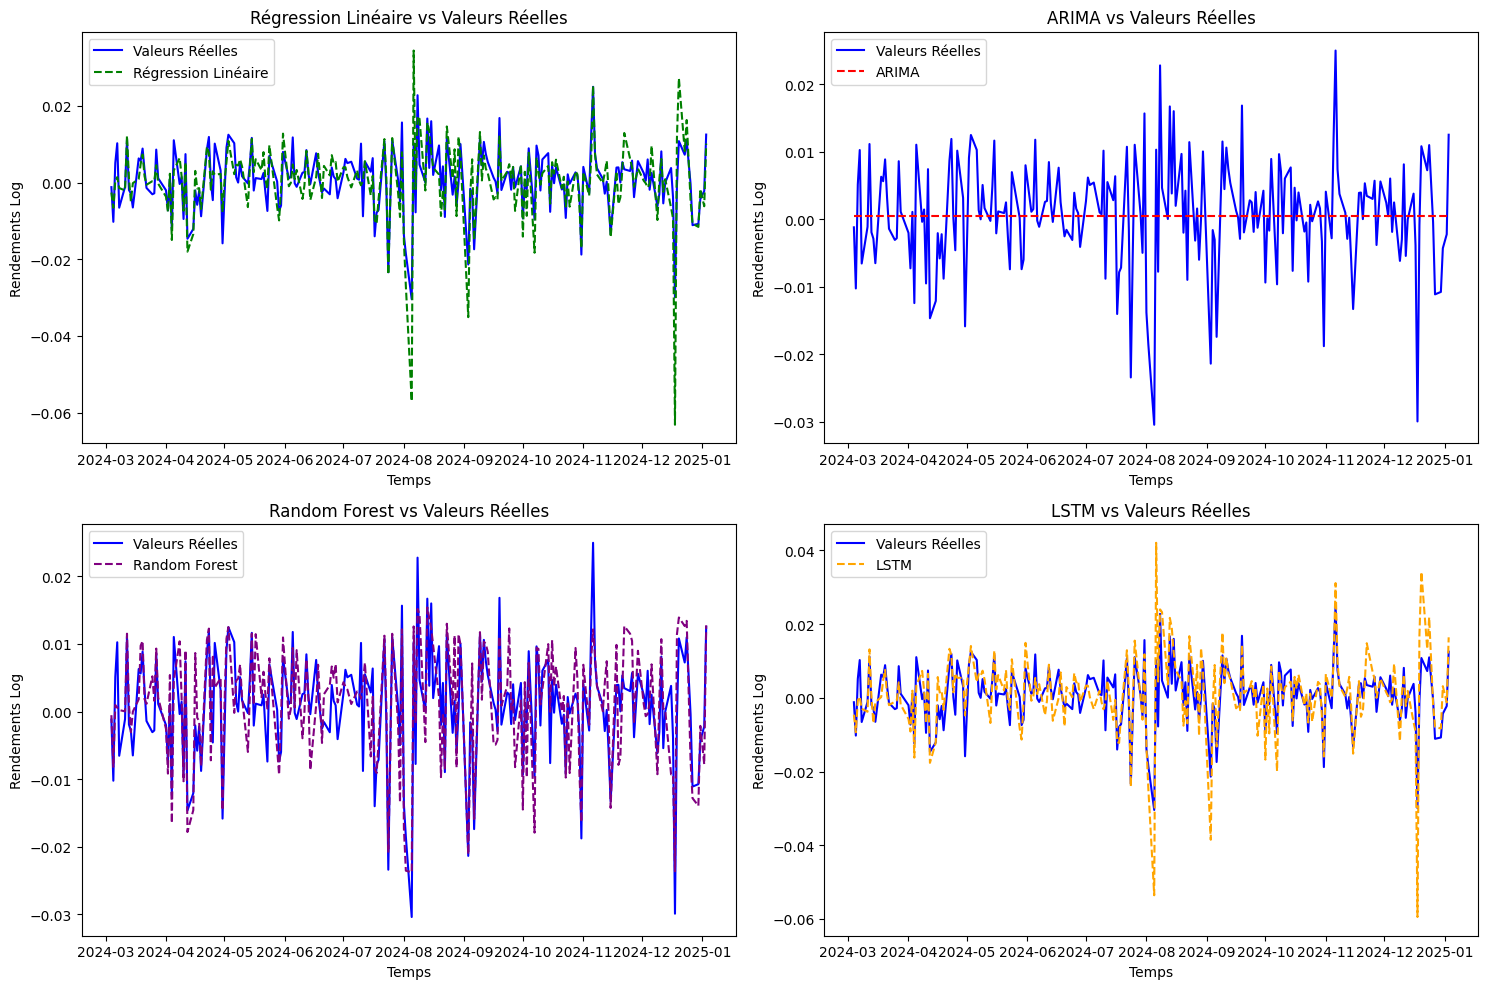

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

tracer_predictions(axes[0, 0], y_test, y_test_pred_lineaire, "Régression Linéaire", "green")

tracer_predictions(axes[0, 1], y_test, y_test_pred_arima, "ARIMA", "red")

tracer_predictions(axes[1, 0], y_test, y_test_pred_rf, "Random Forest", "purple")

tracer_predictions(axes[1, 1], y_test, y_test_pred_lstm, "LSTM", "orange")

plt.tight_layout()
plt.show()

**Visualisation des erreurs absolues**


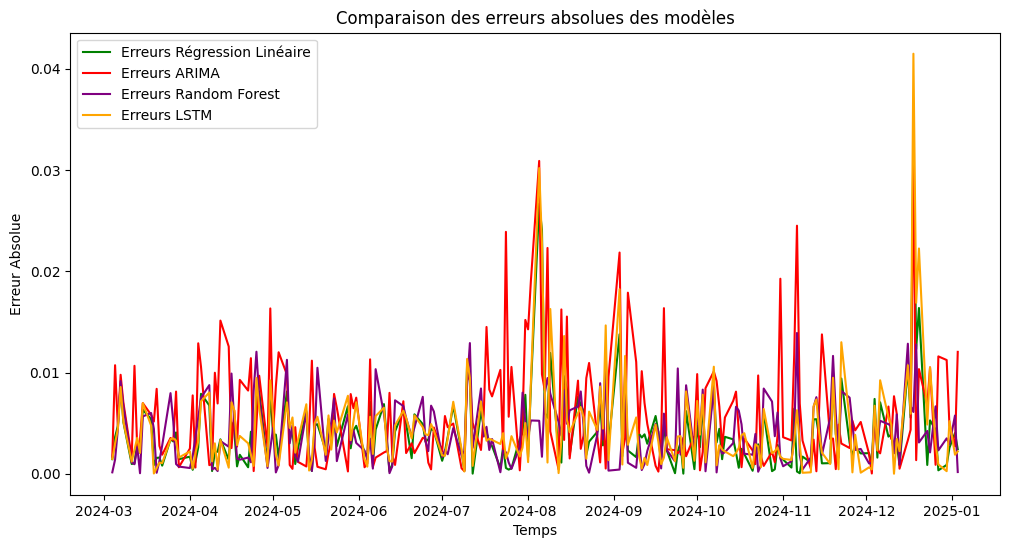

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, abs(y_test - y_test_pred_lineaire), label="Erreurs Régression Linéaire", color="green")
plt.plot(y_test.index, abs(y_test - y_test_pred_arima_aligned), label="Erreurs ARIMA", color="red")
plt.plot(y_test.index, abs(y_test - y_test_pred_rf), label="Erreurs Random Forest", color="purple")
plt.plot(y_test.index, abs(y_test - y_test_pred_lstm_aligned), label="Erreurs LSTM", color="orange")
plt.legend()
plt.title("Comparaison des erreurs absolues des modèles")
plt.xlabel("Temps")
plt.ylabel("Erreur Absolue")
plt.show()

### Discussion sur les erreurs courantes

Dans le raport.

### Conclusion et recommandations

Dans le raport.